<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting VCB  stock price with LSTM



## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time


## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('excel_vcb.csv')

In [5]:
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

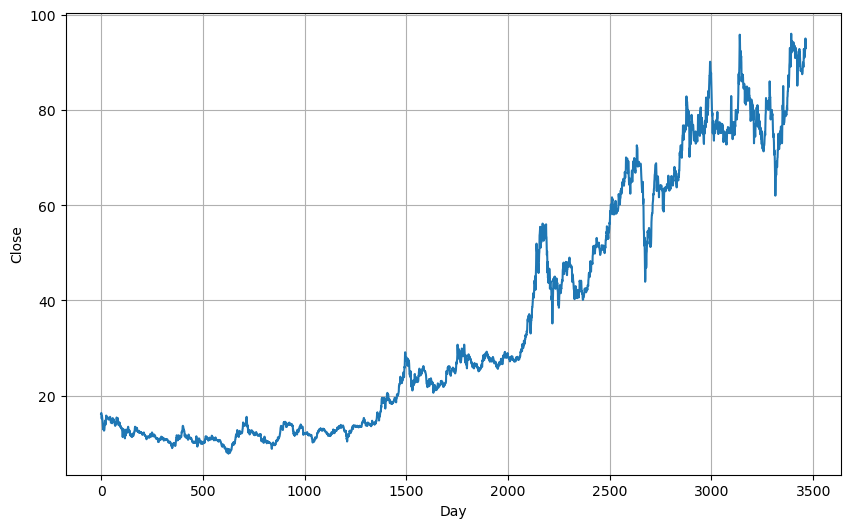

In [6]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the day number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Stock Price

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3464 points in the dataset and you will use the first 3000 for training.

In [7]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("excel_vcb.csv")
cols = ['<Close>']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:

start_time = time.time()
# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)
train_time_cls = time.time() - start_time
print(f'Thời gian huấn luyện mô hình LSTM: {train_time_cls:.4f} giây')

# model.predict(x_test)

# In[44]:
start_time1 = time.time()

model.predict(x_test)

pred_time_cls = time.time() - start_time1
print(f'Thời gian dự đoán mô hình LSTM: {pred_time_cls:.4f} giây')

# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)

# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2944, 1)
data_test.shape (520, 1)
y_test_ori.shape (510, 1)
x_test.shape (510, 9, 1)
y_test.shape (510, 1)
x_train.shape (2934, 9, 1)
y_train.shape (2934, 1)
Epoch 1/5
30/30 [==============================] - 8s 26ms/step - loss: 0.2166
Epoch 2/5
30/30 [==============================] - 1s 32ms/step - loss: 0.1370
Epoch 3/5
30/30 [==============================] - 1s 30ms/step - loss: 0.0832
Epoch 4/5
30/30 [==============================] - 1s 26ms/step - loss: 0.0817
Epoch 5/5
30/30 [==============================] - 1s 26ms/step - loss: 0.0820
Thời gian huấn luyện mô hình LSTM: 12.2568 giây
16/16 [==============================] - 2s 7ms/step
Thời gian dự đoán mô hình LSTM: 1.5870 giây
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step
[[array([0.45012197], dtype=float32)], [array([0.35453802], dtype=float32)], [array([0.354651], dtype=float32)], [array([0.46124405], dtype=float32)], [array([0.41346043], dtype=float32)], [array([0.37201947], dtype=float32)], [array([0.3436175], dtype=float32)], [array([0.34760824], dtype=float32)], [array([0.3553591], dtype=float32)], [array([0.30478376], dtype=float32)], [array([0.21467835], dtype=float32)], [array([0.27470857], dtype=float32)], [array([0.28515604], dtype=float32)], [array([0.3651007], dtype=float32)], [array([0.51426333], dtype=float32)], [array([0.5955113], dtype=float32)], [array([0.6079857], dtype=float32)], [array([0.60768366], dtype=float32)], [array([0.5510606], dtype=float32)], [array([0.5951402], dtype=float32)], [array([0.7509597], dtype=float32)], [array([0.76141244], dtype=float32)], [array([0.73239493], dtype=float32)], [array([0.74323314], dtype=float32)], [array([0.681597], dtype=float32)], [array([0

1/1 [==============================] - 0s 60ms/step
Thời gian dự báo 10 ngày tiếp theo: 2.4172 giây
Dự báo cho 10 ngày tiếp theo: [array(-1.0719694, dtype=float32), array(-1.0887564, dtype=float32), array(-1.1253744, dtype=float32), array(-1.177305, dtype=float32), array(-1.2386439, dtype=float32), array(-1.3009684, dtype=float32), array(-1.3493719, dtype=float32), array(-1.3505435, dtype=float32), array(-1.2142849, dtype=float32), array(-0.63259155, dtype=float32)]


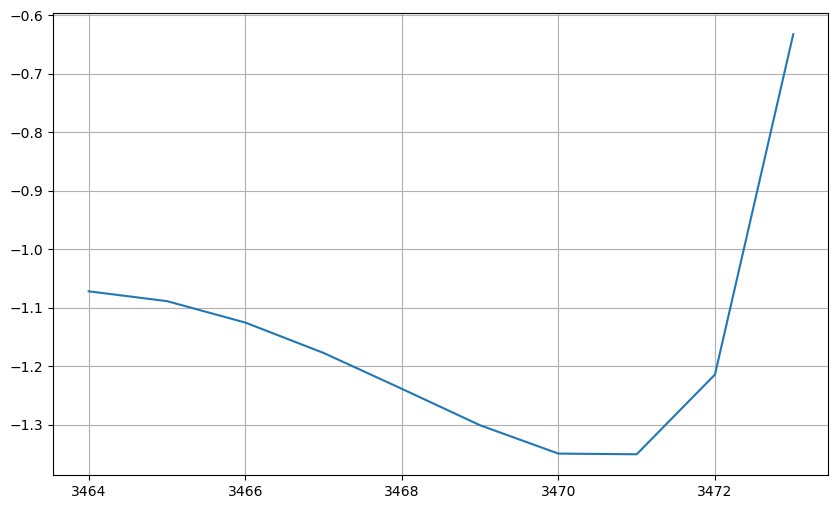

In [14]:
# Bắt đầu tính thời gian dự đoán
start_time = time.time()
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast
# Số ngày cần dự báo
forecast_horizon = 10

# Lấy các giá trị cuối cùng làm đầu vào cho dự báo
input_series = series[-window_size:]  # Lấy dữ liệu cuối với kích thước window_size
predictions = []

# Dự báo từng ngày cho horizon
for _ in range(forecast_horizon):
    # Tạo dự báo cho bước tiếp theo
    forecast = model_forecast(model, input_series, window_size, batch_size)
    next_day_prediction = forecast[-1].squeeze()  # Lấy giá trị dự báo mới nhất
    
    # Thêm vào danh sách dự báo
    predictions.append(next_day_prediction)
    
    # Cập nhật input_series cho lần dự báo tiếp theo
    input_series = np.append(input_series[1:], next_day_prediction)

# Kết thúc tính thời gian dự đoán
train_time_cls = time.time() - start_time
print(f'Thời gian dự báo 10 ngày tiếp theo: {train_time_cls:.4f} giây')

# Hiển thị kết quả dự báo 10 ngày
print("Dự báo cho 10 ngày tiếp theo:", predictions)

# Plot kết quả nếu muốn
plot_series(range(len(series), len(series) + forecast_horizon), predictions)


In [20]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VCB.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 7s 26ms/step - loss: 0.2534
Epoch 2/5
21/21 [==============================] - 1s 26ms/step - loss: 0.1593
Epoch 3/5
21/21 [==============================] - 1s 26ms/step - loss: 0.1301
Epoch 4/5
21/21 [==============================] - 1s 25ms/step - loss: 0.0875
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
[[array([0.58880156], dtype=float32)], [array([0.6406612], dtype=float32)], [array([0.39959905], dtype=float32)], [array([0.24517897], dtype=float32)], [array([0.22796953], dtype=float32)], [array([0.6806535], dtype=float32)], [array([0.8026999], dtype=float32)], [array([0.88753694], dtype=float32)], [array([0.89756733], dtype=float32)], [array([0.8427747], dtype=float32)], [array([0.98665017], dtype=float32)], [array([0.9503151], dtype=float32)], [array([0.9118609], dtype=float32)], [array([0.8618525], dtype=float32)], [array([0.75756526], dtype=float32)], [array([0.6634569], dtype=float32)], [array([0.5900093], dtype=float32)], [array([0.5336692], dtype=float32)], [array([0.73060983], dtype=float32)], [array([0.78193545], dtype=float32)], [array([0.83948857], dtype=float32)], [array([0.8251337], dtype=float32)], [array([0.7669478], dtype=float32)], [array([0.7447128], dtype=float32)], [array([0.7073146], dtype=float32)], [array([0.6

In [35]:
dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\ACB.csv")
cols = ['close']

In [36]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\ACB.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2005, 1)
data_test.shape (354, 1)
y_test_ori.shape (344, 1)
x_test.shape (344, 9, 1)
y_test.shape (344, 1)
x_train.shape (1995, 9, 1)
y_train.shape (1995, 1)
Epoch 1/5
20/20 [==============================] - 7s 37ms/step - loss: 0.2512
Epoch 2/5
20/20 [==============================] - 1s 37ms/step - loss: 0.1617
Epoch 3/5
20/20 [==============================] - 1s 37ms/step - loss: 0.1280
Epoch 4/5
20/20 [==============================] - 1s 37ms/step - loss: 0.0884
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step
[[array([0.36544642], dtype=float32)], [array([0.30417335], dtype=float32)], [array([0.28947452], dtype=float32)], [array([0.38620272], dtype=float32)], [array([0.4001262], dtype=float32)], [array([0.3923033], dtype=float32)], [array([0.22587891], dtype=float32)], [array([0.22216384], dtype=float32)], [array([0.27791998], dtype=float32)], [array([0.29541713], dtype=float32)], [array([0.7512466], dtype=float32)], [array([0.7961587], dtype=float32)], [array([0.8441242], dtype=float32)], [array([0.8477834], dtype=float32)], [array([0.7762217], dtype=float32)], [array([0.6223837], dtype=float32)], [array([0.56399417], dtype=float32)], [array([0.45190188], dtype=float32)], [array([0.3945599], dtype=float32)], [array([0.3457331], dtype=float32)], [array([0.38808778], dtype=float32)], [array([0.51812077], dtype=float32)], [array([0.5485802], dtype=float32)], [array([0.7438942], dtype=float32)], [array([0.7333802], dtype=float32)], [array([0.

In [37]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\DHG.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 45ms/step - loss: 0.2121
Epoch 2/5
21/21 [==============================] - 1s 54ms/step - loss: 0.1448
Epoch 3/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1025
Epoch 4/5
21/21 [==============================] - 1s 45ms/step - loss: 0.0877
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step
[[array([0.6508093], dtype=float32)], [array([0.6458435], dtype=float32)], [array([0.9275682], dtype=float32)], [array([0.9564313], dtype=float32)], [array([0.9336281], dtype=float32)], [array([0.90568924], dtype=float32)], [array([0.84620994], dtype=float32)], [array([0.78793925], dtype=float32)], [array([0.7933651], dtype=float32)], [array([0.7379272], dtype=float32)], [array([0.638574], dtype=float32)], [array([0.7040739], dtype=float32)], [array([0.7765155], dtype=float32)], [array([0.68214005], dtype=float32)], [array([0.6772523], dtype=float32)], [array([0.5270953], dtype=float32)], [array([0.36715725], dtype=float32)], [array([0.41700888], dtype=float32)], [array([0.3822189], dtype=float32)], [array([0.40908188], dtype=float32)], [array([0.48006305], dtype=float32)], [array([0.55011916], dtype=float32)], [array([0.4734833], dtype=float32)], [array([0.74362296], dtype=float32)], [array([0.8835864], dtype=float32)], [array([0.699

In [38]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\FPT.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 43ms/step - loss: 0.2573
Epoch 2/5
21/21 [==============================] - 1s 41ms/step - loss: 0.1578
Epoch 3/5
21/21 [==============================] - 1s 44ms/step - loss: 0.1259
Epoch 4/5
21/21 [==============================] - 1s 45ms/step - loss: 0.0845
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step
[[array([0.18042397], dtype=float32)], [array([0.23764175], dtype=float32)], [array([0.24140248], dtype=float32)], [array([0.32221195], dtype=float32)], [array([0.29131088], dtype=float32)], [array([0.05496904], dtype=float32)], [array([0.09924006], dtype=float32)], [array([0.10086586], dtype=float32)], [array([0.07781814], dtype=float32)], [array([0.14645143], dtype=float32)], [array([0.23193863], dtype=float32)], [array([0.32535848], dtype=float32)], [array([0.39658692], dtype=float32)], [array([0.5397753], dtype=float32)], [array([0.8054557], dtype=float32)], [array([0.8325311], dtype=float32)], [array([0.8391817], dtype=float32)], [array([0.96483666], dtype=float32)], [array([0.9507205], dtype=float32)], [array([0.88136965], dtype=float32)], [array([0.8460182], dtype=float32)], [array([0.73120165], dtype=float32)], [array([0.58035517], dtype=float32)], [array([0.69376606], dtype=float32)], [array([0.66972697], dtype=float32)], [ar

In [39]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\HAP.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2056, 1)
data_test.shape (363, 1)
y_test_ori.shape (353, 1)
x_test.shape (353, 9, 1)
y_test.shape (353, 1)
x_train.shape (2046, 9, 1)
y_train.shape (2046, 1)
Epoch 1/5
21/21 [==============================] - 8s 39ms/step - loss: 0.2167
Epoch 2/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1605
Epoch 3/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1394
Epoch 4/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1046
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step
[[array([0.49891683], dtype=float32)], [array([0.47496828], dtype=float32)], [array([0.41077295], dtype=float32)], [array([0.5126509], dtype=float32)], [array([0.56709206], dtype=float32)], [array([0.569908], dtype=float32)], [array([0.430113], dtype=float32)], [array([0.48228788], dtype=float32)], [array([0.56087315], dtype=float32)], [array([0.912094], dtype=float32)], [array([0.9473189], dtype=float32)], [array([0.9353979], dtype=float32)], [array([0.9034608], dtype=float32)], [array([0.8821289], dtype=float32)], [array([0.8222397], dtype=float32)], [array([0.7268633], dtype=float32)], [array([0.6309733], dtype=float32)], [array([0.48709664], dtype=float32)], [array([0.65085465], dtype=float32)], [array([0.54387826], dtype=float32)], [array([0.4638434], dtype=float32)], [array([0.44687605], dtype=float32)], [array([0.3959226], dtype=float32)], [array([0.37691408], dtype=float32)], [array([0.77802235], dtype=float32)], [array([0.888

In [40]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\HNX.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (1450, 1)
data_test.shape (256, 1)
y_test_ori.shape (246, 1)
x_test.shape (246, 9, 1)
y_test.shape (246, 1)
x_train.shape (1440, 9, 1)
y_train.shape (1440, 1)
Epoch 1/5
15/15 [==============================] - 7s 48ms/step - loss: 0.3025
Epoch 2/5
15/15 [==============================] - 1s 40ms/step - loss: 0.1877
Epoch 3/5
15/15 [==============================] - 1s 38ms/step - loss: 0.1558
Epoch 4/5
15/15 [==============================] - 1s 41ms/step - loss: 0.1055
Epoch 5/5
1/1 [==============================] - 0s 29ms/step
[[array([0.8203175], dtype=float32)], [array([0.71551555], dtype=float32)], [array([0.63499045], dtype=float32)], [array([0.46401218], dtype=float32)], [array([0.2703486], dtype=float32)], [array([0.20244168], dtype=float32)], [array([0.3001165], dtype=float32)], [array([0.25264713], dtype=float32)], [array([0.3652367], dtype=float32)], [array([0.58346957], dtype=float32)], [array([0.7455732], dtype=float32)], [array([0.80033016], dtype=float

In [41]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\HNX30.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (1502, 1)
data_test.shape (266, 1)
y_test_ori.shape (256, 1)
x_test.shape (256, 9, 1)
y_test.shape (256, 1)
x_train.shape (1492, 9, 1)
y_train.shape (1492, 1)
Epoch 1/5
15/15 [==============================] - 7s 41ms/step - loss: 0.3022
Epoch 2/5
15/15 [==============================] - 1s 37ms/step - loss: 0.1883
Epoch 3/5
15/15 [==============================] - 1s 42ms/step - loss: 0.1503
Epoch 4/5
15/15 [==============================] - 1s 39ms/step - loss: 0.0949
Epoch 5/5
1/1 [==============================] - 0s 28ms/step
[[array([0.75440437], dtype=float32)], [array([0.7845937], dtype=float32)], [array([0.6994587], dtype=float32)], [array([0.65499645], dtype=float32)], [array([0.5928232], dtype=float32)], [array([0.54204726], dtype=float32)], [array([0.4176199], dtype=float32)], [array([0.43426773], dtype=float32)], [array([0.46358687], dtype=float32)], [array([0.20943339], dtype=float32)], [array([0.06017376], dtype=float32)], [array([0.10043532], dtype=floa

In [42]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\HPG.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 39ms/step - loss: 0.2617
Epoch 2/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1678
Epoch 3/5
21/21 [==============================] - 1s 41ms/step - loss: 0.1380
Epoch 4/5
21/21 [==============================] - 1s 40ms/step - loss: 0.0876
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step
[[array([0.49536356], dtype=float32)], [array([0.5290621], dtype=float32)], [array([0.5196428], dtype=float32)], [array([0.49776763], dtype=float32)], [array([0.62429076], dtype=float32)], [array([0.9308051], dtype=float32)], [array([0.99954385], dtype=float32)], [array([0.953156], dtype=float32)], [array([0.928804], dtype=float32)], [array([0.9022474], dtype=float32)], [array([0.81299955], dtype=float32)], [array([0.69780165], dtype=float32)], [array([0.5382036], dtype=float32)], [array([0.51795274], dtype=float32)], [array([0.69551903], dtype=float32)], [array([0.8117156], dtype=float32)], [array([0.83262765], dtype=float32)], [array([0.8169378], dtype=float32)], [array([0.7975139], dtype=float32)], [array([0.79963607], dtype=float32)], [array([0.7759701], dtype=float32)], [array([0.70345175], dtype=float32)], [array([0.33894172], dtype=float32)], [array([0.25549588], dtype=float32)], [array([0.1530359], dtype=float32)], [array([0.1

In [46]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\KDC.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8720\3700258568.py:91: RuntimeWarning: invalid value encountered in divide
  temp_col=temp_col/temp_max


Epoch 1/5
21/21 [==============================] - 7s 40ms/step - loss: 0.2399
Epoch 2/5
21/21 [==============================] - 1s 40ms/step - loss: 0.1623
Epoch 3/5
21/21 [==============================] - 1s 40ms/step - loss: 0.1105
Epoch 4/5
21/21 [==============================] - 1s 37ms/step - loss: 0.0893
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 35ms/step
[[array([0.6834976], dtype=float32)], [array([0.65707344], dtype=float32)], [array([0.8359641], dtype=float32)], [array([0.80218035], dtype=float32)], [array([0.70075035], dtype=float32)], [array([0.7266578], dtype=float32)], [array([0.83884346], dtype=float32)], [array([0.84298056], dtype=float32)], [array([0.79274225], dtype=float32)], [array([0.7125607], dtype=float32)], [array([0.7570124], dtype=float32)], [array([0.85175204], dtype=float32)], [array([0.759622], dtype=float32)], [array([0.63064873], dtype=float32)], [array([0.6625098], dtype=float32)], [array([0.5285595], dtype=float32)], [array([0.48417774], dtype=float32)], [array([0.50241786], dtype=float32)], [array([0.4802348], dtype=float32)], [array([0.40586084], dtype=float32)], [array([0.31881216], dtype=float32)], [array([0.27309096], dtype=float32)], [array([0.12326235], dtype=float32)], [array([0.11215894], dtype=float32)], [array([0.0901505], dtype=float32)], [array([

In [45]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\REE.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 47ms/step - loss: 0.2347
Epoch 2/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1600
Epoch 3/5
21/21 [==============================] - 1s 36ms/step - loss: 0.1246
Epoch 4/5
21/21 [==============================] - 1s 35ms/step - loss: 0.0907
Epoch 5/5
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step
[[array([0.22719117], dtype=float32)], [array([0.26337165], dtype=float32)], [array([0.21877453], dtype=float32)], [array([0.19518797], dtype=float32)], [array([0.20202379], dtype=float32)], [array([0.12493947], dtype=float32)], [array([0.00395433], dtype=float32)], [array([0.0855066], dtype=float32)], [array([0.19153295], dtype=float32)], [array([0.26397333], dtype=float32)], [array([0.43759483], dtype=float32)], [array([0.47336435], dtype=float32)], [array([0.6148015], dtype=float32)], [array([0.5927793], dtype=float32)], [array([0.48637813], dtype=float32)], [array([0.38214222], dtype=float32)], [array([0.7504415], dtype=float32)], [array([0.74359155], dtype=float32)], [array([0.7998218], dtype=float32)], [array([0.69930476], dtype=float32)], [array([0.9841779], dtype=float32)], [array([1.0313016], dtype=float32)], [array([0.9972939], dtype=float32)], [array([0.9456445], dtype=float32)], [array([0.94915247], dtype=float32)], [array

mean_error_percent [0.01062129]


In [47]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\SAM.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 7s 37ms/step - loss: 0.2368
Epoch 2/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1662
Epoch 3/5
21/21 [==============================] - 1s 37ms/step - loss: 0.1346
Epoch 4/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1086
Epoch 5/5
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step
[[array([0.2448129], dtype=float32)], [array([0.21157932], dtype=float32)], [array([0.2595584], dtype=float32)], [array([0.29299656], dtype=float32)], [array([0.3711728], dtype=float32)], [array([0.3552409], dtype=float32)], [array([0.3910944], dtype=float32)], [array([0.5205882], dtype=float32)], [array([0.6191497], dtype=float32)], [array([0.8551454], dtype=float32)], [array([0.89000785], dtype=float32)], [array([0.8671909], dtype=float32)], [array([0.8645122], dtype=float32)], [array([0.84371793], dtype=float32)], [array([0.80209726], dtype=float32)], [array([0.84278667], dtype=float32)], [array([0.74688953], dtype=float32)], [array([0.62338555], dtype=float32)], [array([0.6096515], dtype=float32)], [array([0.5279914], dtype=float32)], [array([0.39882925], dtype=float32)], [array([0.24294865], dtype=float32)], [array([0.30355865], dtype=float32)], [array([0.35274246], dtype=float32)], [array([0.5260767], dtype=float32)], [array([0.

MSE [0.0164783]
accuracy [0.98521584]
mean_error_percent [0.01478416]


In [48]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\TMS.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2060, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2050, 9, 1)
y_train.shape (2050, 1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8720\4189732320.py:122: RuntimeWarning: invalid value encountered in divide
  temp_col=temp_col/temp_max


Epoch 1/5
21/21 [==============================] - 7s 40ms/step - loss: nan
Epoch 2/5
21/21 [==============================] - 1s 39ms/step - loss: nan
Epoch 3/5
21/21 [==============================] - 1s 40ms/step - loss: nan
Epoch 4/5
21/21 [==============================] - 1s 39ms/step - loss: nan
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step
[[array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dtype=float32)], [array([nan], dty

In [49]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VIC.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 37ms/step - loss: 0.2446
Epoch 2/5
21/21 [==============================] - 1s 45ms/step - loss: 0.1665
Epoch 3/5
21/21 [==============================] - 1s 40ms/step - loss: 0.1223
Epoch 4/5
21/21 [==============================] - 1s 40ms/step - loss: 0.0939
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step
[[array([0.27009815], dtype=float32)], [array([0.37879434], dtype=float32)], [array([0.35349405], dtype=float32)], [array([0.43589774], dtype=float32)], [array([0.2553988], dtype=float32)], [array([0.1509913], dtype=float32)], [array([0.09523021], dtype=float32)], [array([0.112018], dtype=float32)], [array([0.11142664], dtype=float32)], [array([0.11590318], dtype=float32)], [array([0.14916366], dtype=float32)], [array([0.20741978], dtype=float32)], [array([0.28203493], dtype=float32)], [array([0.39138058], dtype=float32)], [array([0.46349183], dtype=float32)], [array([0.8228874], dtype=float32)], [array([0.78480035], dtype=float32)], [array([0.8674995], dtype=float32)], [array([0.8853248], dtype=float32)], [array([0.83951694], dtype=float32)], [array([0.7822677], dtype=float32)], [array([0.67423874], dtype=float32)], [array([0.5387059], dtype=float32)], [array([0.5265286], dtype=float32)], [array([0.4311843], dtype=float32)], [array([

In [50]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VN30.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (1448, 1)
data_test.shape (256, 1)
y_test_ori.shape (246, 1)
x_test.shape (246, 9, 1)
y_test.shape (246, 1)
x_train.shape (1438, 9, 1)
y_train.shape (1438, 1)
Epoch 1/5
15/15 [==============================] - 7s 36ms/step - loss: 0.3220
Epoch 2/5
15/15 [==============================] - 1s 37ms/step - loss: 0.1929
Epoch 3/5
15/15 [==============================] - 1s 36ms/step - loss: 0.1624
Epoch 4/5
15/15 [==============================] - 1s 36ms/step - loss: 0.1301
Epoch 5/5
1/1 [==============================] - 0s 26ms/step
[[array([0.85689837], dtype=float32)], [array([0.91555685], dtype=float32)], [array([0.8740433], dtype=float32)], [array([0.8039931], dtype=float32)], [array([0.7183761], dtype=float32)], [array([0.68658596], dtype=float32)], [array([0.6342671], dtype=float32)], [array([0.49240446], dtype=float32)], [array([0.4381704], dtype=float32)], [array([0.54261076], dtype=float32)], [array([0.72379106], dtype=float32)], [array([0.91971606], dtype=float

In [51]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VNINDEX.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2060, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2050, 9, 1)
y_train.shape (2050, 1)
Epoch 1/5
21/21 [==============================] - 8s 38ms/step - loss: 0.2951
Epoch 2/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1755
Epoch 3/5
21/21 [==============================] - 1s 40ms/step - loss: 0.1421
Epoch 4/5
21/21 [==============================] - 1s 38ms/step - loss: 0.0868
Epoch 5/5
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step
[[array([0.0656319], dtype=float32)], [array([0.10006648], dtype=float32)], [array([0.14107005], dtype=float32)], [array([0.19411223], dtype=float32)], [array([0.26443216], dtype=float32)], [array([0.2907388], dtype=float32)], [array([0.12702158], dtype=float32)], [array([0.2126491], dtype=float32)], [array([0.35424888], dtype=float32)], [array([0.30193287], dtype=float32)], [array([0.62370837], dtype=float32)], [array([0.774296], dtype=float32)], [array([0.8680904], dtype=float32)], [array([0.8506484], dtype=float32)], [array([0.98896456], dtype=float32)], [array([0.9155726], dtype=float32)], [array([0.8155327], dtype=float32)], [array([0.7717444], dtype=float32)], [array([0.6147777], dtype=float32)], [array([0.82094187], dtype=float32)], [array([0.73647594], dtype=float32)], [array([0.7178805], dtype=float32)], [array([0.56778353], dtype=float32)], [array([0.50508195], dtype=float32)], [array([0.5332624], dtype=float32)], [array([0.

In [52]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\VNM.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)
Epoch 1/5
21/21 [==============================] - 8s 37ms/step - loss: 0.2326
Epoch 2/5
21/21 [==============================] - 1s 37ms/step - loss: 0.1562
Epoch 3/5
21/21 [==============================] - 1s 38ms/step - loss: 0.1301
Epoch 4/5
21/21 [==============================] - 1s 39ms/step - loss: 0.0913
Epoch 5/5
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 25ms/step
[[array([0.10988824], dtype=float32)], [array([0.1550732], dtype=float32)], [array([0.13435656], dtype=float32)], [array([0.20965376], dtype=float32)], [array([0.26405096], dtype=float32)], [array([0.24181657], dtype=float32)], [array([0.22253633], dtype=float32)], [array([0.3259816], dtype=float32)], [array([0.2797642], dtype=float32)], [array([0.22388002], dtype=float32)], [array([0.33074984], dtype=float32)], [array([0.2586469], dtype=float32)], [array([0.38301942], dtype=float32)], [array([0.47404432], dtype=float32)], [array([0.48911557], dtype=float32)], [array([0.57843965], dtype=float32)], [array([0.5324445], dtype=float32)], [array([0.55419946], dtype=float32)], [array([0.41529772], dtype=float32)], [array([0.21362105], dtype=float32)], [array([0.24134582], dtype=float32)], [array([0.1896955], dtype=float32)], [array([0.11860065], dtype=float32)], [array([0.11514165], dtype=float32)], [array([0.1862998], dtype=float32)], [arr

In [53]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


# In[42]:


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("D:\DeTaiNam2024\SoLieuHong\KDC.csv")
cols = ['close']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

#get_test_data    
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

#get_train_data 
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


# In[43]:


# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


# model.predict(x_test)

# In[44]:


model.predict(x_test)


# In[46]:


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
    
print(prediction_seqs)


# In[48]:


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)


# In[50]:


error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



data_train.shape (2062, 1)
data_test.shape (364, 1)
y_test_ori.shape (354, 1)
x_test.shape (354, 9, 1)
y_test.shape (354, 1)
x_train.shape (2052, 9, 1)
y_train.shape (2052, 1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8720\3700258568.py:91: RuntimeWarning: invalid value encountered in divide
  temp_col=temp_col/temp_max


Epoch 1/5
21/21 [==============================] - 7s 38ms/step - loss: 0.2376
Epoch 2/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1651
Epoch 3/5
21/21 [==============================] - 1s 39ms/step - loss: 0.1320
Epoch 4/5
21/21 [==============================] - 1s 39ms/step - loss: 0.0910
Epoch 5/5
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 20ms/step
[[array([0.69281334], dtype=float32)], [array([0.6672851], dtype=float32)], [array([0.8696177], dtype=float32)], [array([0.82943445], dtype=float32)], [array([0.7145383], dtype=float32)], [array([0.7463067], dtype=float32)], [array([0.8697412], dtype=float32)], [array([0.8750855], dtype=float32)], [array([0.8193986], dtype=float32)], [array([0.72997063], dtype=float32)], [array([0.7800037], dtype=float32)], [array([0.88336897], dtype=float32)], [array([0.7768118], dtype=float32)], [array([0.63326997], dtype=float32)], [array([0.6667669], dtype=float32)], [array([0.5233267], dtype=float32)], [array([0.47705773], dtype=float32)], [array([0.49882284], dtype=float32)], [array([0.47832218], dtype=float32)], [array([0.4034382], dtype=float32)], [array([0.30753133], dtype=float32)], [array([0.25886658], dtype=float32)], [array([0.10651244], dtype=float32)], [array([0.09837365], dtype=float32)], [array([0.08286099], dtype=float32)], [array([0